In [21]:
import pandas as pd
import datetime 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import numpy as np
from datetime import timedelta
import math
import warnings
warnings.filterwarnings("ignore")

In [90]:
data = pd.read_csv('pharma/salesweekly.csv',parse_dates=['datum'],index_col='datum')

In [91]:
data['Year'] = pd.DatetimeIndex(data.index).year
data['Month'] = pd.DatetimeIndex(data.index).month

In [92]:
data.head()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month
datum,,,,,,,,,,
2014-01-05,14.00,11.67,21.3,185.95,41.0,0.0,32.0,7.0,2014,1
2014-01-12,29.33,12.68,37.9,190.70,88.0,5.0,21.0,7.2,2014,1
2014-01-19,30.67,26.34,45.9,218.40,80.0,8.0,29.0,12.0,2014,1
2014-01-26,34.00,32.37,31.5,179.60,80.0,8.0,23.0,10.0,2014,1
2014-02-02,31.02,23.35,20.7,159.88,84.0,12.0,29.0,12.0,2014,2


In [93]:
n_estimators = [int(x) for x in np.linspace(start = 5,stop = 15,num=11)]
max_depth = [int(x) for x in np.linspace(3,10,num=7)]

## M01AB

In [94]:
cols = ["M01AB","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['M01AB'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['M01AB'].shift(1)
df['lag2'] = df['M01AB'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']

In [95]:
df

,M01AB,Year,Month,MA,lag1,lag2
0,14.00,2014,1,0.000000,0.00,0.00
1,29.33,2014,1,0.000000,14.00,0.00
2,30.67,2014,1,24.666667,29.33,14.00
3,34.00,2014,1,31.333333,30.67,29.33
4,31.02,2014,2,31.896667,34.00,30.67
...,...,...,...,...,...,...
297,35.51,2019,9,35.526667,40.71,30.36
298,46.84,2019,9,41.020000,35.51,40.71
299,34.01,2019,9,38.786667,46.84,35.51
300,38.70,2019,10,39.850000,34.01,46.84


In [96]:
features = df.drop(['M01AB'],axis=1)
target = df['M01AB']
x_train = features[:-12]
y_train = target[:-12]
x_test = features[-12:]
y_test = target[-12:]
y_test = np.asarray(y_test)

In [98]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)

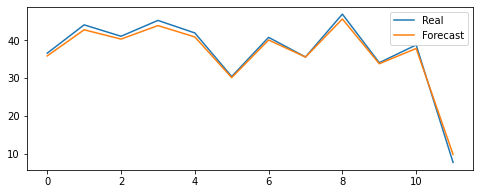

In [99]:
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [100]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

1.0560616660398927


In [101]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 8}

In [102]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=8)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)

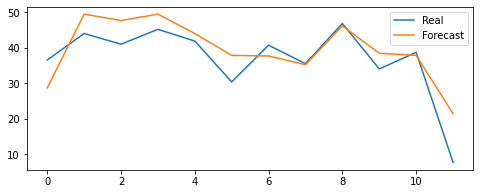

In [103]:
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [104]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

6.008495175633014


In [105]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 10, 'n_estimators': 11}

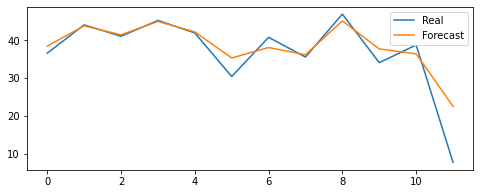

In [106]:
rf = RandomForestRegressor(random_state = 1,max_depth = 10,n_estimators = 11)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [107]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

4.797213289762375


In [108]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.3,0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 10,
 'n_estimators': 15}

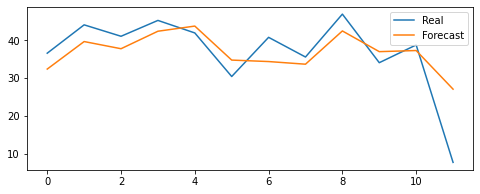

In [109]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 10,colsample_bytree= 0.7,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [110]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

6.630658110180562


## M01AE

In [111]:
cols = ["M01AE","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['M01AE'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['M01AE'].shift(1)
df['lag2'] = df['M01AE'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']

In [112]:
features = df.drop(['M01AE'],axis=1)
target = df['M01AE']
x_train = features[:-12]
y_train = target[:-12]
x_test = features[-12:]
y_test = target[-12:]
y_test = np.asarray(y_test)

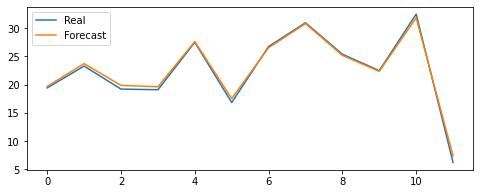

In [113]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [114]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

0.5292218904432713


In [115]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 10}

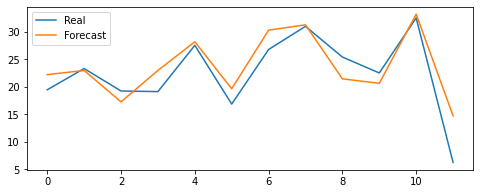

In [116]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=10)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [117]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

3.396767053635953


In [118]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 10, 'n_estimators': 15}

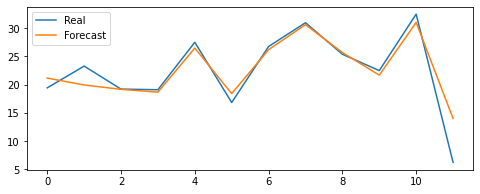

In [119]:
rf = RandomForestRegressor(random_state = 1,max_depth = 10,n_estimators = 15)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [120]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

2.6115641557597606


In [121]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 4,
 'n_estimators': 15}

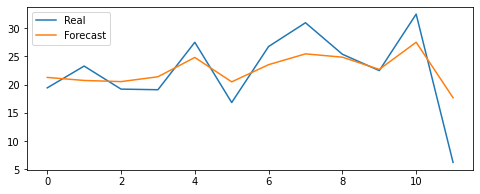

In [122]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 4,colsample_bytree= 0.7,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [123]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

4.422084299464688


## N02BA

In [126]:
cols = ["N02BA","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['N02BA'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['N02BA'].shift(1)
df['lag2'] = df['N02BA'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']
features = df.drop(['N02BA'],axis=1)
target = df['N02BA']
x_train = features[:-12]
y_train = target[:-12]
x_test = features[-12:]
y_test = target[-12:]
y_test = np.asarray(y_test)

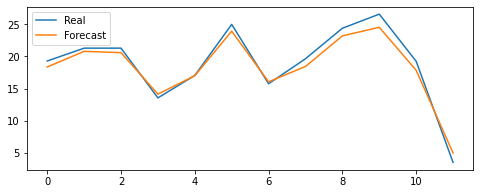

In [127]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [128]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

1.0920979779128164


In [129]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 10}

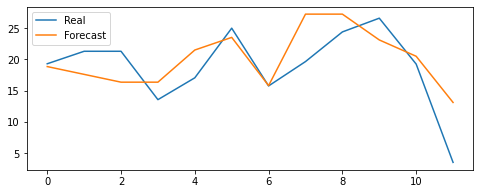

In [130]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=10)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [131]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

4.471709554811515


In [132]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 10, 'n_estimators': 14}

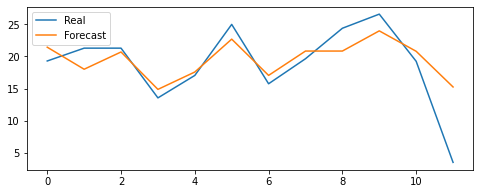

In [133]:
rf = RandomForestRegressor(random_state = 1,max_depth = 10,n_estimators = 14)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [134]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

3.938291815929045


In [135]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 6,
 'n_estimators': 15}

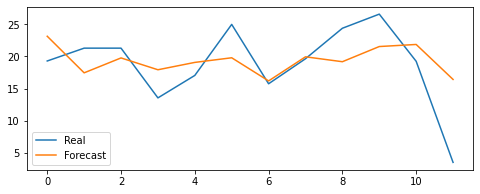

In [136]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 6,colsample_bytree= 0.7,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [137]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

5.076405376378274


## N02BE

In [138]:
cols = ["N02BE","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['N02BE'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['N02BE'].shift(1)
df['lag2'] = df['N02BE'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']
features = df.drop(['N02BE'],axis=1)
target = df['N02BE']
x_train = features[:-12]
y_train = target[:-12]
x_test = features[-12:]
y_test = target[-12:]
y_test = np.asarray(y_test)

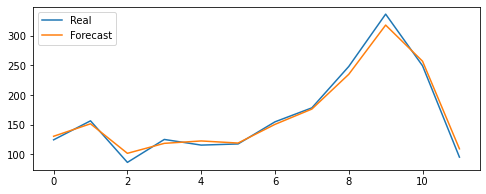

In [139]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [140]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

9.94117334044092


In [141]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 10}

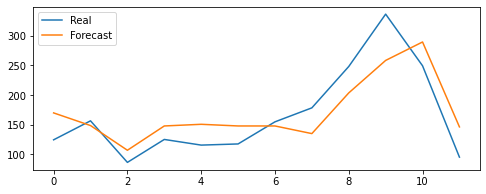

In [142]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=10)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [143]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

40.31613198988526


In [144]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 10, 'n_estimators': 14}

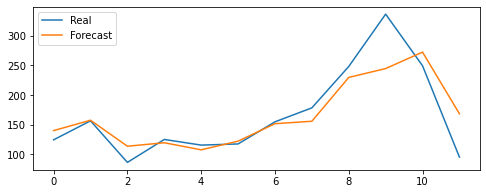

In [145]:
rf = RandomForestRegressor(random_state = 1,max_depth = 10,n_estimators = 14)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [146]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

36.879745237361256


In [147]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 15}

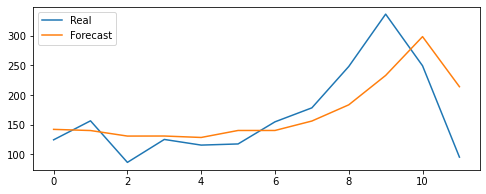

In [148]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 3,colsample_bytree= 0.7,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [149]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

54.38148121384469


## N05B

In [150]:
cols = ["N05B","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['N05B'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['N05B'].shift(1)
df['lag2'] = df['N05B'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']
features = df.drop(['N05B'],axis=1)
target = df['N05B']
x_train = features[:-12]
y_train = target[:-12]
x_test = features[-12:]
y_test = target[-12:]
y_test = np.asarray(y_test)

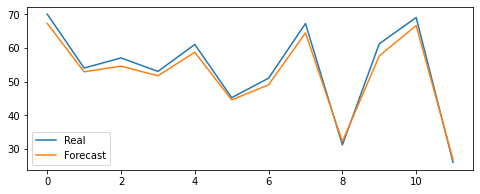

In [151]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [152]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

2.1231739031854526


In [153]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 6}

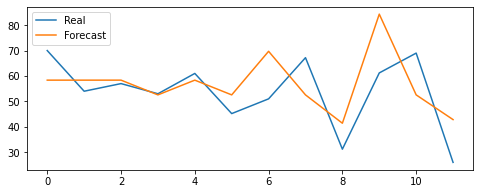

In [154]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=6)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [155]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

12.829164309228654


In [156]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 10, 'n_estimators': 15}

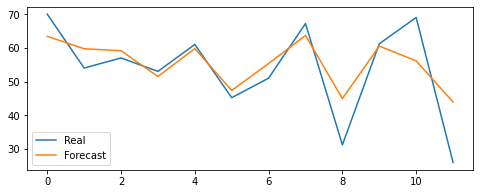

In [157]:
rf = RandomForestRegressor(random_state = 1,max_depth = 10,n_estimators = 15)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [158]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

8.147762949020482


In [159]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 15}

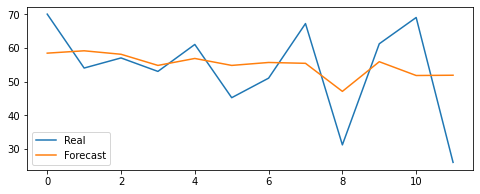

In [160]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 3,colsample_bytree= 0.7,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [161]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

11.83324121819275


## N05C

In [163]:
cols = ["N05C","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['N05C'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['N05C'].shift(1)
df['lag2'] = df['N05C'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']
features = df.drop(['N05C'],axis=1)
target = df['N05C']
x_train = features[:-12]
y_train = target[:-12]
x_test = features[-12:]
y_test = target[-12:]
y_test = np.asarray(y_test)

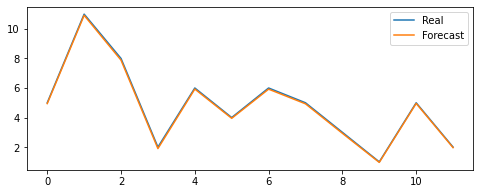

In [164]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [165]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

0.07123524857599789


In [166]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 10}

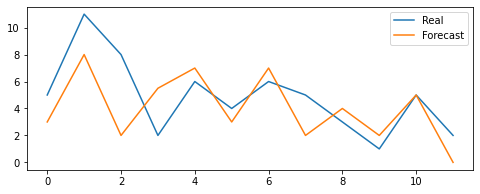

In [167]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=10)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [168]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

2.569857324184879


In [169]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 10, 'n_estimators': 15}

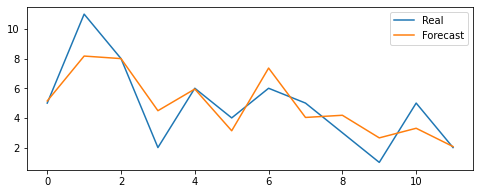

In [170]:
rf = RandomForestRegressor(random_state = 1,max_depth = 10,n_estimators = 15)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [171]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

1.4362628355421603


In [172]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 15}

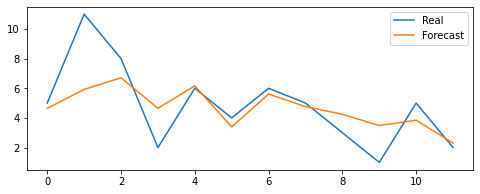

In [173]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 3,colsample_bytree= 0.7,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [174]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

1.9224413639692406


## R03

In [175]:
cols = ["R03","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['R03'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['R03'].shift(1)
df['lag2'] = df['R03'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']
features = df.drop(['R03'],axis=1)
target = df['R03']
x_train = features[:-12]
y_train = target[:-12]
x_test = features[-12:]
y_test = target[-12:]
y_test = np.asarray(y_test)

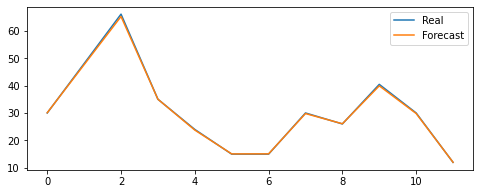

In [176]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [177]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

0.33690453653438635


In [178]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 10}

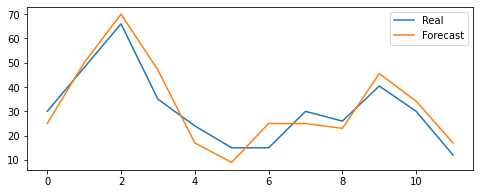

In [179]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=10)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [180]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

6.30132444903377


In [181]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 10, 'n_estimators': 15}

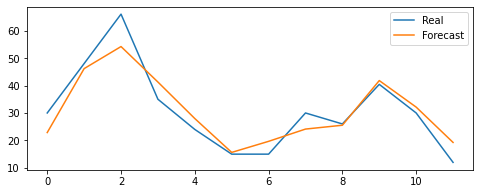

In [182]:
rf = RandomForestRegressor(random_state = 1,max_depth = 10,n_estimators = 15)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [183]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

5.513954144770315


In [184]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 15}

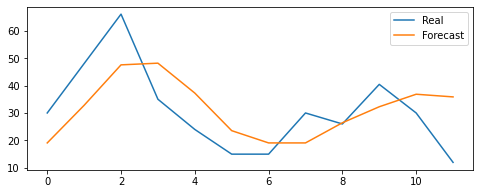

In [185]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 3,colsample_bytree= 0.7,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [186]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

12.684680481508744


## R06

In [187]:
cols = ["R06","Year","Month"]
df = data.loc[:,cols]
arr_mean = df['R06'].rolling(3).mean()
df['MA'] = arr_mean
df['lag1'] = df['R06'].shift(1)
df['lag2'] = df['R06'].shift(2)
df.fillna(0,inplace=True)
df = df.reset_index()
del df['datum']
features = df.drop(['R06'],axis=1)
target = df['R06']
x_train = features[:-12]
y_train = target[:-12]
x_test = features[-12:]
y_test = target[-12:]
y_test = np.asarray(y_test)

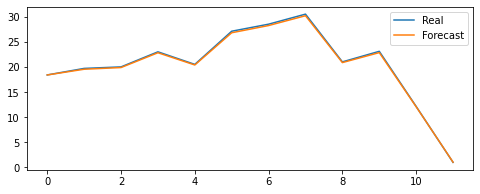

In [188]:
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
predictions = lr_model.predict(x_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [189]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

0.1928183342911665


In [190]:
dt_model = DecisionTreeRegressor(criterion='mse')
parameters = {
    'max_depth' : max_depth
}
model = GridSearchCV(dt_model, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 7}

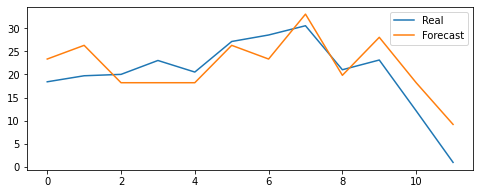

In [191]:
dt_model = DecisionTreeRegressor(criterion='mse',max_depth=7)
dt_model.fit(x_train,y_train)
predictions = dt_model.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [192]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

4.674739681304507


In [193]:
rf = RandomForestRegressor(random_state = 1)
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth
    
}

model = GridSearchCV(rf, param_grid=parameters, scoring='neg_mean_absolute_error', cv=10)
model.fit(x_train,y_train)
model.best_params_

{'max_depth': 8, 'n_estimators': 13}

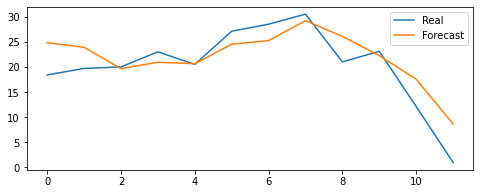

In [194]:
rf = RandomForestRegressor(random_state = 1,max_depth = 8,n_estimators = 13)
rf.fit(x_train, y_train)
predictions = rf.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [195]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

4.049796289789385


In [196]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror')
parameters = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
    'colsample_bytree': [0.5, 0.7],
    'learning_rate' : [0.05, 0.10, 0.15, 0.20]
    
}
model = GridSearchCV(xg, param_grid=parameters,cv=3)
model.fit(x_train,y_train)
model.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.2,
 'max_depth': 3,
 'n_estimators': 15}

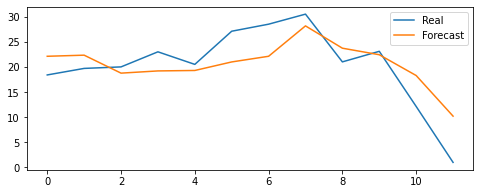

In [197]:
xg = xgb.XGBRegressor(objective = 'reg:squarederror',n_estimators = 15,max_depth = 3,colsample_bytree= 0.7,learning_rate=0.2)
xg.fit(x_train,y_train)
predictions = xg.predict(x_test)
y_test = np.asarray(y_test)
fig = plt.figure(figsize=(8,3))
plt.plot(y_test,label='Real')
plt.plot(predictions,label='Forecast')
plt.legend()

In [198]:
rmse = math.sqrt(mean_squared_error(y_test,predictions))
print(rmse)

4.584857307948924
